## JDSZR6, Jonasz Krawczyk
### Praca domowa nr 12

### treść zadania:

Poniżej podany jest zestaw danych. Zawiera on brakujące wartości. Twoim zadaniem jest przygotować ten zestaw danych do obróbki a następnie wytrenować klasyfikator przewidujący choroby serca dobierając ilość kroków oraz learning rate.

Wartością docelową jest num

Twoim celem jest odrzucenie zmiennych charakteryzujących się dużą ilością wartości brakujących oraz uzupełnienie pozostałych kolumn. Użyj do tego na przykład funkcji pd.DataFrame.isna, pd.DataFrame.sum oraz metody pd.Series.fillna.

Użyj metody xgb.cv do ustalenia przebiegu treningu. Postaraj się dobrać takie wartości ilości kroków oraz learning rate aby przeuczyć (overfit) klasyfikator. Zacznij od learning rate 0.01. Kiedy klasyfikator zostanie przetrenowany, użyj wykresu błędu w zależności od ilości kroków aby wyznaczyć przybliżoną optymalną ilość drzew dla danego modelu i wytrenuj ostateczny model.

Dodatkowe info: xgb obsługuje brakujące wartości przez parametr missing. Możesz (nie musisz) użyć tego zamiast interpolacji brakujących wartości.

Po estymacji modelu porównaj jego wynik ze zbudowanym przez siebie modelem KNN na tym samym zbiorze.


------

### import bibliotek

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from collections import Counter

from numpy import sqrt
from numpy import argmax

import xgboost as xgb
import time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, roc_auc_score, mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, roc_curve, plot_roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from scipy.interpolate import make_interp_spline

from mlxtend.evaluate import bias_variance_decomp

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'scikitplot'

### 1. przegląd danych, analiza

In [2]:
df = pd.read_csv('heart.csv')

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,?,?,?,0
1,29,1,2,120,243,0,0,160,0,0.0,?,?,?,0
2,29,1,2,140,?,0,0,170,0,0.0,?,?,?,0
3,30,0,1,170,237,0,1,170,0,0.0,?,?,6,0
4,31,0,2,100,219,0,1,150,0,0.0,?,?,?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         294 non-null    int64  
 1   sex         294 non-null    int64  
 2   cp          294 non-null    int64  
 3   trestbps    294 non-null    object 
 4   chol        294 non-null    object 
 5   fbs         294 non-null    object 
 6   restecg     294 non-null    object 
 7   thalach     294 non-null    object 
 8   exang       294 non-null    object 
 9   oldpeak     294 non-null    float64
 10  slope       294 non-null    object 
 11  ca          294 non-null    object 
 12  thal        294 non-null    object 
 13  num         294 non-null    int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 32.3+ KB


In [5]:
df.shape

(294, 14)

In [6]:
df.describe()

,age,sex,cp,oldpeak,num
count,294.000000,294.000000,294.000000,294.000000,294.000000
mean,47.826531,0.724490,2.982993,0.586054,0.360544
std,7.811812,0.447533,0.965117,0.908648,0.480977
min,28.000000,0.000000,1.000000,0.000000,0.000000
25%,42.000000,0.000000,2.000000,0.000000,0.000000
50%,49.000000,1.000000,3.000000,0.000000,0.000000
75%,54.000000,1.000000,4.000000,1.000000,1.000000
max,66.000000,1.000000,4.000000,5.000000,1.000000


In [7]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num       '],
      dtype='object')

Tragedia z tą nazwą ostatniej kolumny. Przemianuję ją na coś bardziej zrozumiałego i bez tego śmisznego odstępu.

In [8]:
df = df.rename(columns={'num       ': 'y'}) 

In [9]:
df["y"].value_counts()

0    188
1    106
Name: y, dtype: int64

Zmienna jest nawet nienajgorzej zbalansowana. Nie muszę tu szczególnie czarować przy podziale zbioru na treningowy i testowy. Przy okazji - zbiór wydaje się zbyt mały na sporządzenie zbioru walidacyjnego; to także pominę.

Sprawdzę o co chodzi z tymi Nanami tutaj

In [10]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
y           0
dtype: int64

nic.

In [11]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
y           0
dtype: int64

nadal nic.

Niby nic, ale w df.head() widać jakieś braki danych, w postaci znaku '?'. No i trener ma zawsze rację przeca. Trzeba drążyć dalej.

In [12]:
cols = df.columns
cols

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'y'],
      dtype='object')

In [13]:
for i, col in enumerate(cols):
    print(col)
    print("missing infos: ", (df[str(col)] == "?").sum())

age
missing infos:  0
sex
missing infos:  0
cp
missing infos:  0
trestbps
missing infos:  1
chol
missing infos:  23
fbs
missing infos:  8
restecg
missing infos:  1
thalach
missing infos:  1
exang
missing infos:  1
oldpeak
missing infos:  0
slope
missing infos:  190
ca
missing infos:  291
thal
missing infos:  266
y
missing infos:  0


Coś udało się znaleść. Teraz - skoro cały dataset ma ogólnie 294 wiersze to ciężko rozważać uzupełnianie danymi mocno wybrakowanych kolumn "slope", "ca", "thal".

Z drugiej strony usuwanie wierszy zawierających '?' sprawi, że dataset wynikowo może w zasadzie całkiem zniknąć. Można pokasować problematyczne kolumny, zanim jednak tego dokonam, sprawdzę czy nie są skorelowane z targetem.

Ponieważ '?' jest stringiem - przepuszczę dataframe'a przez labelencoder; inaczej kolumny zawierające ten znak byłyby pominięte.

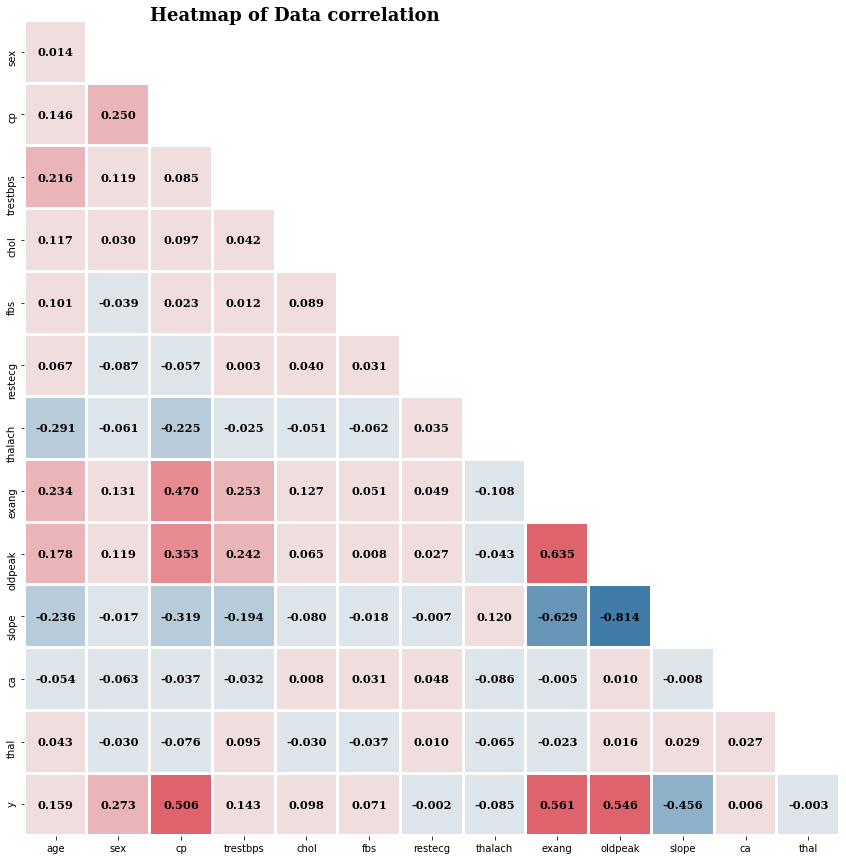

In [14]:
le = LabelEncoder()

plt.figure(figsize=(15, 15))
df_copy1 = df.copy()
objList = df_copy1.select_dtypes(include="object").columns

for col in objList:
    df_copy1[col] = le.fit_transform(df_copy1[col].astype(str))

df_corr = df_copy1.corr()
color_map = sns.diverging_palette(240, 10, n=10)
mask = np.triu(np.ones_like(df_corr), k=0)
mask = mask[1:, :-1]
corr = df_corr.iloc[1:, :-1].copy()
sns.heatmap(corr,
            mask=mask,
            annot=True,
            fmt=".3f",
            cmap=color_map,
            center=0,
            vmin=-0.82,
            vmax=0.64,
            cbar=False,
            linewidth=2,
            square=True,
            annot_kws={
                'font': 'serif',
                'size': 11.5,
                'color': 'black',
                'fontweight': 'bold'
            })
plt.text(2,
         0,
         'Heatmap of Data correlation',
         fontsize=18,
         fontweight='bold',
         fontfamily='serif')
pass

In [15]:
cor_ranking = df_corr['y'].sort_values(ascending = False)
cor_ranking_abs = abs(cor_ranking)
cor_ranking_abs.sort_values(ascending = False)

y           1.000000
exang       0.561015
oldpeak     0.545700
cp          0.505864
slope       0.455687
sex         0.272781
age         0.159315
trestbps    0.143390
chol        0.098397
thalach     0.085366
fbs         0.070786
ca          0.005754
thal        0.002986
restecg     0.002276
Name: y, dtype: float64

### 2. czyszczenie danych

Zmienne 'ca' oraz 'thal' nie są skorelowane z 'y'; nie mam oporów przed usunięciem ich. Trudniejsza sprawa jest ze 'slope' który wykazuje relatywnie dużą korelację z targetem. Z drugiej strony usunięcie tylko NaNów (tu '?') spowoduje konkretne zredukowanie zbioru:

In [16]:
print('total rows:   ', df.shape[0])
print('missing rows: ', (df['slope'] == "?").sum())
print('resulted size:', (df.shape[0]) - (df['slope'] == "?").sum())

total rows:    294
missing rows:  190
resulted size: 104


Nie mogę zrezygnować z 2/3 objętości informacji. Nie wyobrażam sobie też żebym tutaj zmienną uzupełniał danymi i udawał, że to ma nadal jakiś związek z rzeczywistością. Na potrzeby ćwiczenia kolumnę teraz usunę. Gdyby natomiast taka sytuacja spotkała mnie w życiu to zgłosiłbym sprawę przełożonemu informując o istotności zmiennej, tzn. jej usunięcie wpłynie na wiarygodność budowanego dalej predyktora, choćbym niewiem jak go dotrenował. W każdym razie spostrzeżenie takiej kwestii musi być wyartykułowane. End-user czy właściciel danych także powienin to wiedzieć. A może nagle ktoś stwierdzi, że jest szansa na uzupełnienie tych danych, kto wie?

Kolejna kwestia, która rzuca się w oczy po wyprintowaniu heatmapy korelacji: zmienne Slope i oldpeak są ze sobą silnie skorelowane (powyżej 0.8). Zgodnie ze sztuką - z dwóch zmiennych silnie skorelowanych jednej można się pozbyć. Tu akurat tak się fartownie złożyło, że członkiem pary jest wyżej omawiany Slope. Znalazł się więc drugi powód do usunięcia tej zmiennej.

In [17]:
df.drop(['slope', 'ca', 'thal'], axis=1, inplace=True)

Teraz trzeba zająć się kwestią zmiennych, które są wybrakowane w takich ilościach, dla których można rozważać uzupełnianie informacji. Wg wcześniejszych treści, są to kolumny: trestbps, chol, fbs, restecg, thalach, exang. Wyprintuję jeszcze raz te treści.

In [18]:
partially_empty = [
    'exang', 'trestbps', 'chol', 'thalach', 'fbs', 'restecg', 'y'
]

In [19]:
partial_df = df[partially_empty]

In [20]:
partial_cols = partial_df.columns

df_copy2 = partial_df.copy()
objList = df_copy2.select_dtypes(include="object").columns

for col in objList:
    df_copy2[col] = le.fit_transform(df_copy2[col].astype(str))
df_corr2 = df_copy2.corr()

for col in partial_cols:
    print(col)
    print("missing infos: ", (df[str(col)] == "?").sum())

cor_ranking2 = df_corr2['y'].sort_values(ascending=False)
cor_ranking_abs2 = abs(cor_ranking2)
cor_ranking_abs2.sort_values(ascending=False)

exang
missing infos:  1
trestbps
missing infos:  1
chol
missing infos:  23
thalach
missing infos:  1
fbs
missing infos:  8
restecg
missing infos:  1
y
missing infos:  0


y           1.000000
exang       0.561015
trestbps    0.143390
chol        0.098397
thalach     0.085366
fbs         0.070786
restecg     0.002276
Name: y, dtype: float64

Usunąłbym zmienne nieskorelowane. Skoro jednak _"Twoim celem jest odrzucenie zmiennych charakteryzujących się dużą ilością wartości brakujących oraz **uzupełnienie pozostałych** kolumn"_ to wypełnię je danymi. W tym przypadku jest to o tyle trudne, że nie ma  zwykłych NaNów dla których można przyłożyć df.fillna(), dodatkowo nie idzie policzyć średniej z kolumn które zawierają znak niepoliczalny ('?'), patrz:

In [21]:
try:
    df['chol'].mean()
except TypeError:
    print('Python could not convert variable to numeric')

Python could not convert variable to numeric


widzę kilka dróg rozwiązania problemu:

a) te kolumny do uzupełnienia: 
* osobno skopiować, 
* usunąć z nich '?', 
* policzyć ich średnie, 
* które potem podstawić do odnośnych kolumn dfa np. metodą replace() lub inaczej zamaist '?'.

ponieważ rozważane jest wstawienie wartości średniej to - przed tem jednak należałoby sprawdzić i zająć się outlierami.

b) w zasadzie jak w _a_, jednak z tą różnicą, że zamiast wstawiania średniej wstawić interpolację z sąsiadów.

c) spróbować podstawić jednak NaN w miejsce _nieliczb_ i zastosować fillna()

Zasadniczo w poleceniu zasugerowano interpolację (patrz "dodatkowe info"). Zanim jednak zdecyduję czy tak rzeczywiście zrobić to popatrzę na rozkłady zmiennych, może trzeba zastosować dla nich różne metody uzupełniainia.

Najpierw outliery:

In [22]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'y'],
      dtype='object')

<AxesSubplot:>

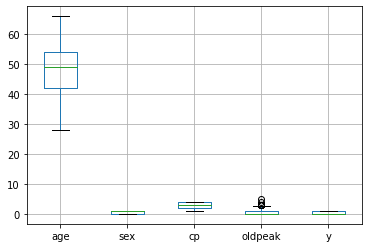

In [23]:
df.boxplot()

nie namalował mi wszystkiego, trzeba rozpracować typ danych

In [24]:
columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
    'exang', 'oldpeak', 'y'
]
ne_cols = [
    'age_', 'sex_', 'cp_', 'trestbps_', 'chol_', 'fbs_', 'restecg_',
    'thalach_', 'exang_', 'oldpeak_', 'y_'
]

In [25]:
d = {}
for i, col in enumerate(columns):
    for j, ne_col in enumerate(ne_cols):
        if i == j:
            d['{}'.format(ne_col)] = df[columns[i]].drop(
                df.index[df[columns[i]] == '?']).astype('float')

Teraz idzie je zobaczyć:

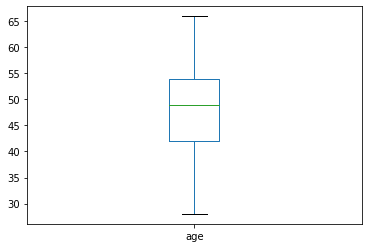

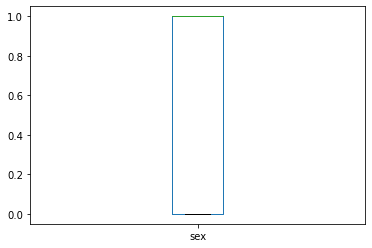

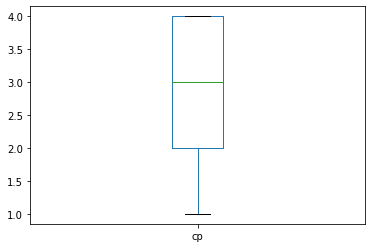

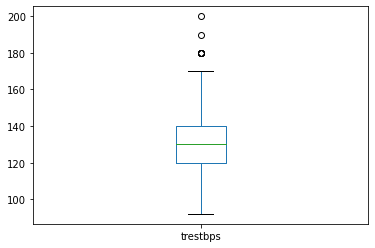

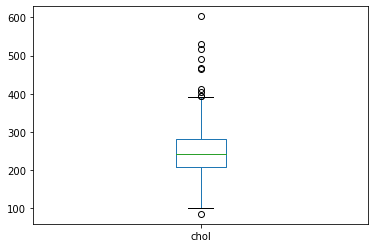

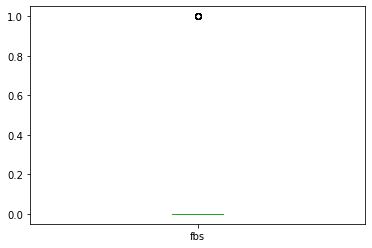

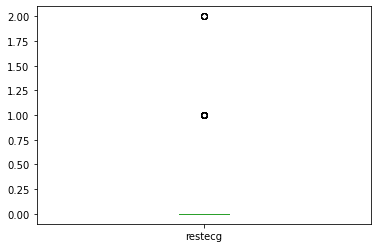

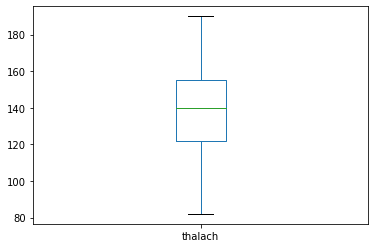

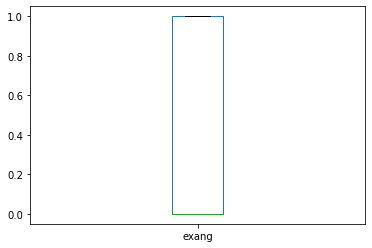

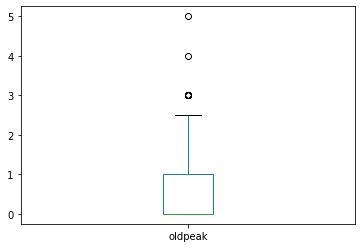

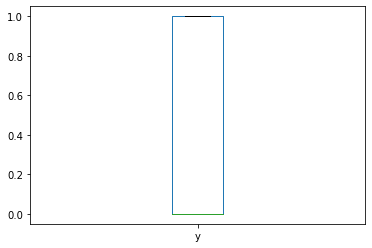

In [26]:
for j, new in enumerate(ne_cols):
    d['{}'.format(new)].plot(kind='box')
    plt.show()

Usunę outliery ze zmiennych 'trestbps' i 'chol', to ledwie kilka obserwacji do usunięcia z dfa a pomoże wpisać bardziej adekwatne wartości w miejsca naszych braków. 
Może nie jest to najlepszy pomysł w ujęciu danych medycznych, tymbardziej, że te outliery nie są gdzieś w kosmosie, ale tutaj warto to zrobić choćby szkoleniowo; dla przyuczenia.

In [27]:
df = pd.DataFrame(d)

In [28]:
cols = ['trestbps_', 'chol_']

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] >
                                           (Q3 + 1.5 * IQR))).any(axis=1)]

<AxesSubplot:>

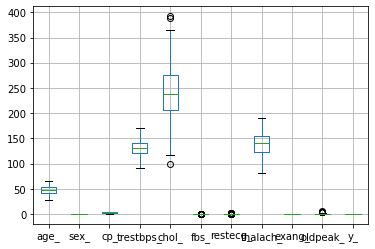

In [29]:
df.boxplot()

outliery zostały usunięte z kolumn, dla których było to uzasadnione a nie zostały usunięte dla zmiennych gdzie byłoby to błędem (np. fbs czy restec).
Przy okazji nadpisania dfa przez słownik pojawiły się zwykłe NaNy, co odkryłem raczej przypadkowo:

In [30]:
df.isna().sum()

age_          0
sex_          0
cp_           0
trestbps_     1
chol_        22
fbs_          6
restecg_      1
thalach_      1
exang_        1
oldpeak_      0
y_            0
dtype: int64

Outliery usuwałem po to aby adekwatnie wyliczyć średnie zmiennych. Zapiszę je sobie do słownika, mogą się przydać później.

In [31]:
d1={}
for key, value in d.items():
    value = np.array(value)
    value = np.reshape(value, -1)
    value = np.mean(value)
    d1 = {key: value}
    d.update(d1)

In [32]:
d

{'age_': 47.826530612244895,
 'sex_': 0.7244897959183674,
 'cp_': 2.9829931972789114,
 'trestbps_': 132.5836177474403,
 'chol_': 250.84870848708488,
 'fbs_': 0.06993006993006994,
 'restecg_': 0.21843003412969283,
 'thalach_': 139.1296928327645,
 'exang_': 0.3037542662116041,
 'oldpeak_': 0.5860544217687075,
 'y_': 0.36054421768707484}

wróćmy do pytania czy bardziej interpolować NaNy czy zastępować średnimi. HistPlot.

In [33]:
def get_quant_features(dataframe):
    feats = dataframe.select_dtypes([np.number, np.bool]).columns
    return [x for x in feats]

In [34]:
def draw_histograms(dataframe, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(16,24))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        dataframe[var_name].hist(bins=20,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()
    plt.show()

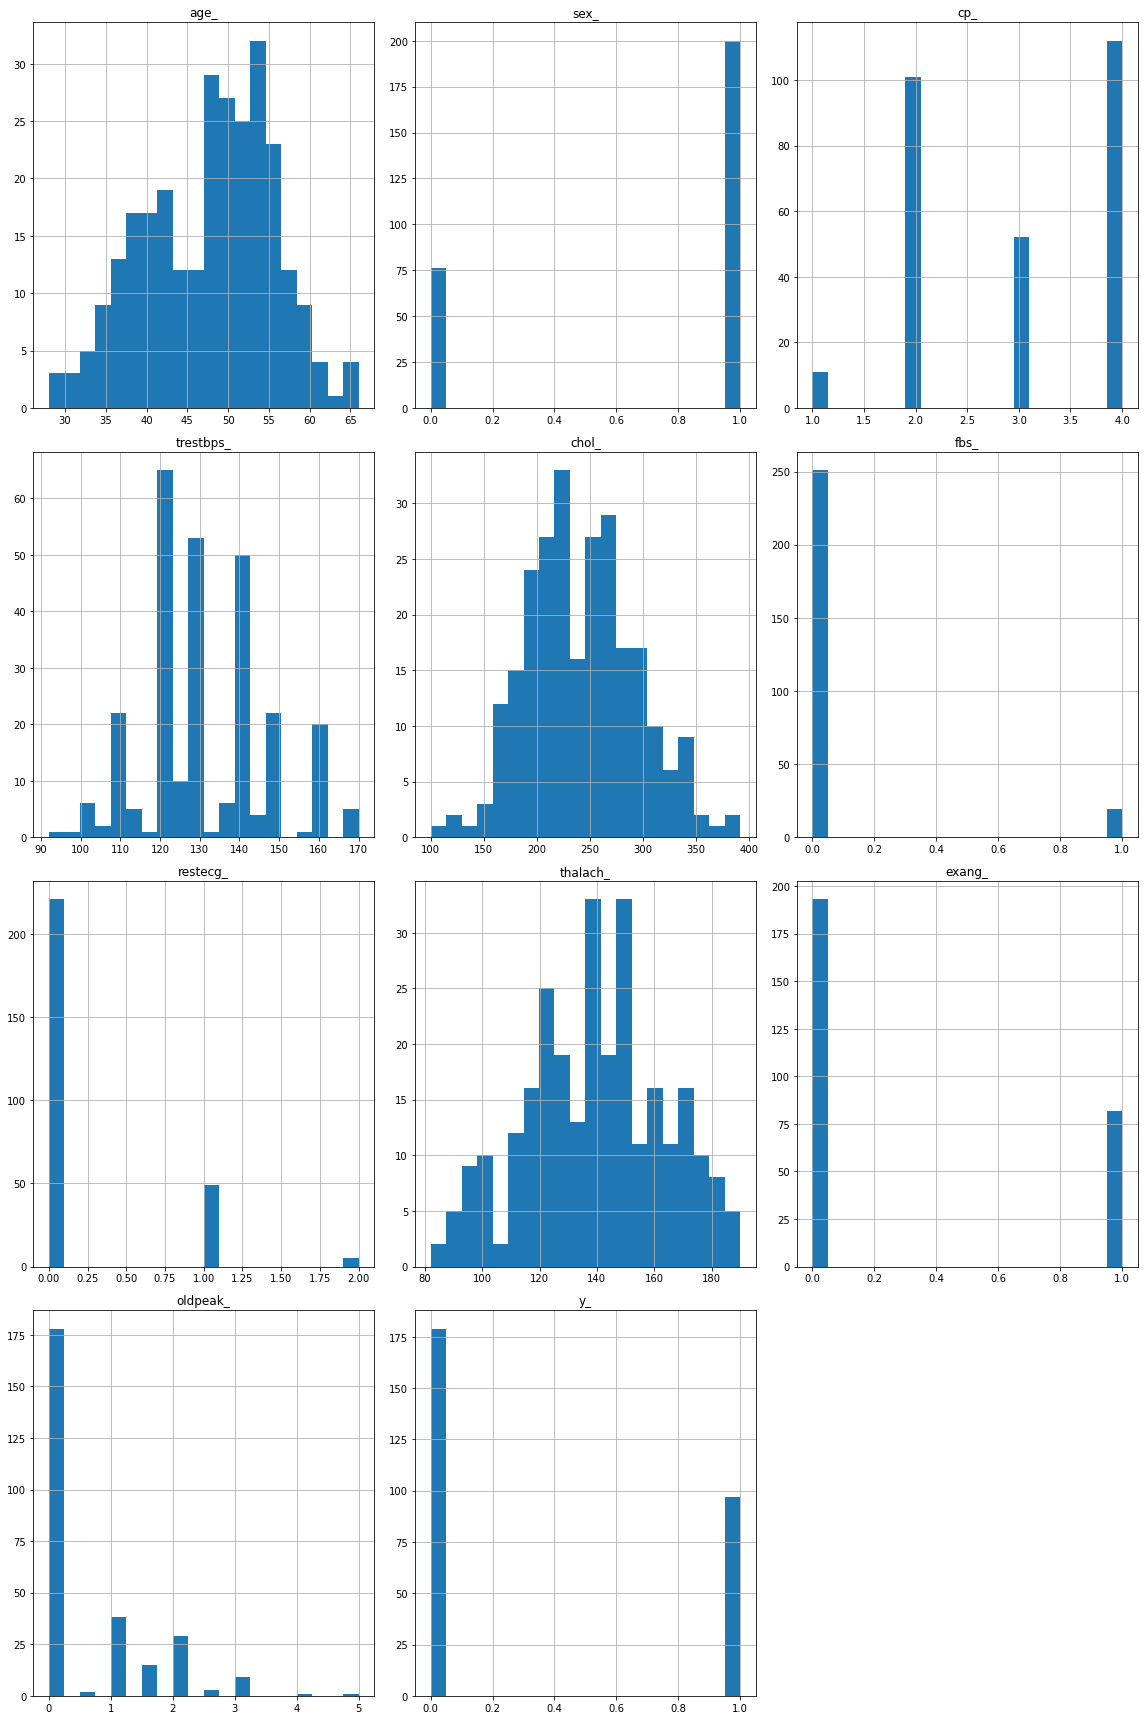

In [35]:
feats = get_quant_features(df)
draw_histograms(df, feats, 4, 3)

* trestbps ma 1 brak, rozkład problematyczny. Wstawię tam interpolację jeżeli dana nie jest akurat w otoczeniu "dołka" w innym przypadku wstawię średnią.
* chol ma rozkład zbliżony do normalnego, 22 braki. Interpoluję jego NaNy.
* fbs jest zmienną 0-1 więc nadanie średniej lub interpolacji wprowadzi tu nową kategorię, trzeba użyć 0 albo 1. Przy 6 brakach i niewielkim udziale jedynek - powstawiam wszędzie zera.
* restecg ma 3 kategorie więc potrzeba zdecydować się na jedną z nich. Na pierwszy rzut oka wstawienie 0 wydaje sę bezpieczne.
* thalach ma rozkład raczej normalny bez jakichś wyraźnych lokalnych ekstremów. jeden brak. Wstawię mu średnią lub interpolację w przeciwnej zależności od tego co wyjdzie w trestbps - dla przećwiczenia obu podstawień.
* exang dostanie ode mnie jedno zero w miejsce swojego Nana

**trestbps**

In [36]:
df.trestbps_.isna().sum()

1

In [37]:
nan_rows = df[df['trestbps_'].isnull()]
nan_rows

,age_,sex_,cp_,trestbps_,chol_,fbs_,restecg_,thalach_,exang_,oldpeak_,y_
90,48.0,0.0,2.0,NaN,308.0,0.0,1.0,NaN,NaN,2.0,0.0


In [38]:
df[['trestbps_']].query('index > 85 and index < 95')

,trestbps_
86,130.0
87,110.0
88,160.0
89,140.0
90,NaN
91,120.0
92,120.0
93,120.0
94,108.0


Wracając do wykresu ciężko określić co będzie lepsze. Tutaj jednak zarówno interpolacja jak i średnia dają około 130. Ponieważ zmienna raczej wygląda skokowo co 10, to użyję interpolacji bo średnia ma tam jakieś dziadostwa po przecinku.

In [39]:
df.trestbps_.interpolate(inplace=True)

In [40]:
df[['trestbps_']].query('index > 87 and index < 93')

,trestbps_
88,160.0
89,140.0
90,130.0
91,120.0
92,120.0


**chol**

In [41]:
df.chol_.isna().sum()

22

In [42]:
df.chol_.interpolate(inplace=True)

In [43]:
df.chol_.isna().sum()

0

**fbs**

In [44]:
df.fbs_.isna().sum()

6

In [45]:
df.fbs_.fillna(0, inplace=True)

In [46]:
df.fbs_.isna().sum()

0

**restecg**

In [47]:
df.restecg_.isna().sum()

1

In [48]:
df.restecg_.fillna(0, inplace=True)

In [49]:
df.restecg_.isna().sum()

0

**thalach**

In [50]:
df.thalach_.isna().sum()

1

In [51]:
d['thalach_']

139.1296928327645

In [52]:
nan_rows = df[df['thalach_'].isnull()]
nan_rows

,age_,sex_,cp_,trestbps_,chol_,fbs_,restecg_,thalach_,exang_,oldpeak_,y_
90,48.0,0.0,2.0,130.0,308.0,0.0,1.0,NaN,NaN,2.0,0.0


In [53]:
df.thalach_.fillna(d['thalach_'], inplace=True)

In [54]:
df[['thalach_']].query('index == 90')

,thalach_
90,139.129693


**exang**

In [55]:
df.exang_.isna().sum()

1

In [56]:
df.exang_.fillna(0, inplace=True)

In [57]:
df.exang_.isna().sum()

0

**pozostaje sprawdzenie wszystkiego**

In [58]:
df.isna().sum()

age_         0
sex_         0
cp_          0
trestbps_    0
chol_        0
fbs_         0
restecg_     0
thalach_     0
exang_       0
oldpeak_     0
y_           0
dtype: int64

In [59]:
df.describe()

,age_,sex_,cp_,trestbps_,chol_,fbs_,restecg_,thalach_,exang_,oldpeak_,y_
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,47.706522,0.724638,2.960145,131.181159,243.134058,0.068841,0.213768,139.554818,0.297101,0.590580,0.351449
std,7.825652,0.447508,0.965894,15.656650,50.048707,0.253643,0.452820,23.693809,0.457812,0.919952,0.478290
min,28.000000,0.000000,1.000000,92.000000,100.000000,0.000000,0.000000,82.000000,0.000000,0.000000,0.000000
25%,42.000000,0.000000,2.000000,120.000000,208.750000,0.000000,0.000000,122.000000,0.000000,0.000000,0.000000
50%,48.000000,1.000000,3.000000,130.000000,240.000000,0.000000,0.000000,140.000000,0.000000,0.000000,0.000000
75%,54.000000,1.000000,4.000000,140.000000,276.000000,0.000000,0.000000,155.000000,1.000000,1.000000,1.000000
max,66.000000,1.000000,4.000000,170.000000,392.000000,1.000000,2.000000,190.000000,1.000000,5.000000,1.000000


przywrócę mu jeszcze oryginalne nazwy zmiennych na koniec przygotówek

In [60]:
df.columns

Index(['age_', 'sex_', 'cp_', 'trestbps_', 'chol_', 'fbs_', 'restecg_',
       'thalach_', 'exang_', 'oldpeak_', 'y_'],
      dtype='object')

In [61]:
df.columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
    'exang', 'oldpeak', 'y'
]

In [62]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'y'],
      dtype='object')

(Jeszcze tylko wracając do samych danych: zmiennych jest kilka, wartości niedużo - uważam, że analiza PCA nie jest najlepszym pomysłem tutaj. Ponieważ jednak mam zastosować XGB i KNN to w dobrym guście będzie standaryzacja jak mniemam.)

(Outliery - mógłbym je także zmienić na NaN a potem interpolować, np. metodą:
df.loc[(df['kolumna'] > wartość)]  = np.nan)

### 3. zdefiniowanie zbiorów

In [63]:
X = df.drop(columns="y", axis=1)
y = df["y"]

In [64]:
for i in range(1, 100, 1):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.25,
                                                        random_state=i)
    y_train1 = y_train.value_counts()[1]
    y_train0 = y_train.value_counts()[0]
    y_train_ratio = round((y_train1 / y_train0), 3)
    y_test1 = y_test.value_counts()[1]
    y_test0 = y_test.value_counts()[0]
    y_test_ratio = round((y_test1 / y_test0), 3)
    if (y_test_ratio - 0.015) <= y_train_ratio <= (y_test_ratio + 0.015):
        print("examplary nice split random_state: ", i)
        break

examplary nice split random_state:  6


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=6)

In [66]:
print('target ratio in train set:\n',
      round(y_train.value_counts()[1] / y_train.value_counts()[0], 3))
print('target ratio in test set:\n',
      round(y_test.value_counts()[1] / y_test.value_counts()[0], 3))

target ratio in train set:
 0.545
target ratio in test set:
 0.533


Utworzę tu jeszcze standaryzowanego dfa, jako kopię aby w razie potrzeby łatwo się przełączać między danymi standaryzowanymi a przygotowanymi wg punktu 2.

In [67]:
scaler = StandardScaler()
features = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
    'exang', 'oldpeak'
]

In [68]:
dfs = df.copy()
dfs[features] = scaler.fit_transform(dfs[features])

In [69]:
Xs = dfs.drop(columns="y", axis=1)
ys = dfs["y"]

In [70]:
for i in range(1, 100, 1):
    Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs,
                                                        ys,
                                                        test_size=0.25,
                                                        random_state=i)
    ys_train1 = ys_train.value_counts()[1]
    ys_train0 = ys_train.value_counts()[0]
    ys_train_ratio = round((ys_train1 / ys_train0), 3)
    ys_test1 = ys_test.value_counts()[1]
    ys_test0 = ys_test.value_counts()[0]
    ys_test_ratio = round((ys_test1 / ys_test0), 3)
    if (ys_test_ratio - 0.015) <= ys_train_ratio <= (ys_test_ratio + 0.015):
        print("examplary nice split random_state: ", i)
        break

examplary nice split random_state:  6


In [71]:
Xs_train, Xs_test, ys_train, sy_test = train_test_split(Xs,
                                                    ys,
                                                    test_size=0.25,
                                                    random_state=6)

In [72]:
print('target ratio in train set:\n',
      round(ys_train.value_counts()[1] / ys_train.value_counts()[0], 3))
print('target ratio in test set:\n',
      round(ys_test.value_counts()[1] / ys_test.value_counts()[0], 3))

target ratio in train set:
 0.545
target ratio in test set:
 0.533


### 4. wybór metryki walidacji

Niewiele wiemy o zbiorze. Ma on rzekomo informować o chorobach serca, gdzie wyjściem jest kolumna 'y' (wcześniej 'num'); zero-jedynkowa. Zakładam więc, że 1 to choroba serca, 0 znaczy zdrowie. <br>
Przyjmuję, że chcemy aby klasyfikator znajdywał jedynki (TP), choćby w rzeczywistości nimi nie były (FP) aby każdego pacjenta z oznakami chorób serca skierować z rejestracji do lekarza w trybie cito a nie do zwykłej kolejki. Oznacza to, że chcemy aby każdy podejrzany pacjent został zbadany przez specjalistę (priorytet na tzw. zmarnowany wysiłek). <br>
Podstawową metryką będzie więc Precission. Pomocniczo, dla ogólnej oceny modelu może być accuracy a także będę wyznaczał pole pod krzywą ROC.

### 5. modelowanie

Zgodnie z treścią zadania - model powinien zostać przeuczony. To znaczy powinien charakteryzować się niskim biasem i dużą wariancją, a mniej ściśle: taki model będzie dobrze predykował zbiór treningowy i słabo zbór testowy. <br> 
W przypadku XGBoost aby uniknąć overfittingu na przykład na model nakłada się kary za złożoność, odpowiadają za to hiperparametry _alpha_ i _lambda_ ; ich zadaniem jest zmniejszenie wariancji kosztem obciążenia.<br>
Wg. dokumentacji: _"Increasing this value will make model more conservative."_ rozumiem, że będzie bardziej zachowawczy znaczy nie będzie agresywnie zwiększał swojej złożoności. <br>
Mamy jednak użyć learning_rate i n_estimators.

#### 5.1 przebiegi metryk oceny modelu

Na początek rzucę okiem jak kształtują się wybrane metyki oceny wobec zmian zadanych hiperparametrów.

**5.1.1 metryki - learning_rate**

In [73]:
lr_vals = np.linspace(0.01,
                      1,
                      num=51,
                      endpoint=True,
                      retstep=False,
                      dtype=None,
                      axis=0)
lr_vals

array([0.01  , 0.0298, 0.0496, 0.0694, 0.0892, 0.109 , 0.1288, 0.1486,
       0.1684, 0.1882, 0.208 , 0.2278, 0.2476, 0.2674, 0.2872, 0.307 ,
       0.3268, 0.3466, 0.3664, 0.3862, 0.406 , 0.4258, 0.4456, 0.4654,
       0.4852, 0.505 , 0.5248, 0.5446, 0.5644, 0.5842, 0.604 , 0.6238,
       0.6436, 0.6634, 0.6832, 0.703 , 0.7228, 0.7426, 0.7624, 0.7822,
       0.802 , 0.8218, 0.8416, 0.8614, 0.8812, 0.901 , 0.9208, 0.9406,
       0.9604, 0.9802, 1.    ])

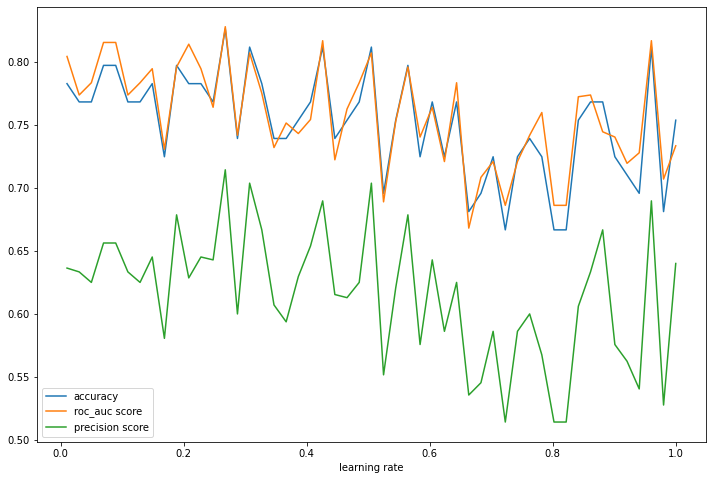

In [74]:
acc_score = []
roc_auc_sc = []
prec_score = []

for l in lr_vals:
    xgb_cl = xgb.XGBClassifier(learning_rate=l,
                               objective='binary:hinge',
                               eval_metric='rmse'
                              )
    xgb_cl.fit(Xs_train, ys_train)
    
    y_pred = xgb_cl.predict(Xs_test)
    acc = accuracy_score(ys_test, y_pred)
    prec = precision_score(ys_test, y_pred)
    acc_score.append(acc)
    prec_score.append(prec)
    probas = xgb_cl.predict_proba(Xs_test)
    positive_proba = probas[:, 1]
    roc_auc_sc.append(roc_auc_score(ys_test, positive_proba))

plt.figure(figsize=(12, 8))
plt.plot(lr_vals, acc_score, label='accuracy')
plt.plot(lr_vals, roc_auc_sc, label='roc_auc score')
plt.plot(lr_vals, prec_score, label='precision score')
plt.xlabel("learning rate")
plt.legend()
pass

Może kształtuje się jakaś zależność ale jej nie widać przez zbyt gęste próbkowanie. Najlepiej byłoby przyłożyć regresję do tych przebiegów, wygładzę je jednak graficznie.

In [75]:
lr_vals = np.linspace(0.01,
                      1,
                      num=16,
                      endpoint=True,
                      retstep=False,
                      dtype=None,
                      axis=0)

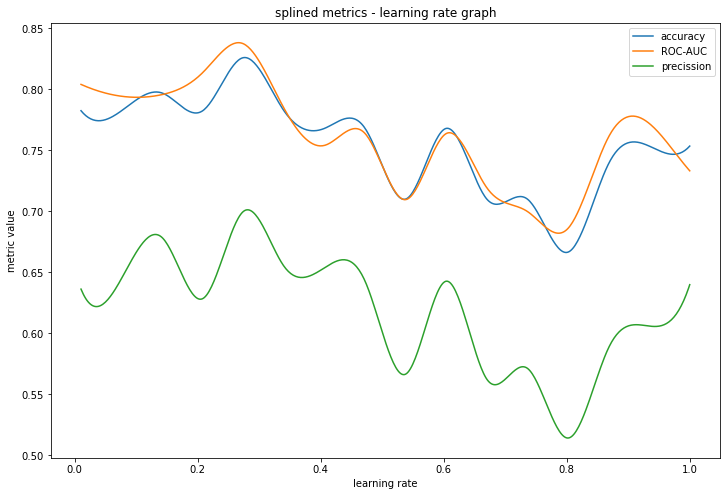

In [76]:
acc_score = []
roc_auc_sc = []
prec_score = []

for l in lr_vals:
    xgb_cl = xgb.XGBClassifier(learning_rate=l,
                               objective='binary:hinge',
                               eval_metric='rmse'
                              )
    xgb_cl.fit(Xs_train, ys_train)
    
    y_pred = xgb_cl.predict(Xs_test)
    acc = accuracy_score(ys_test, y_pred)
    prec = precision_score(ys_test, y_pred)
    acc_score.append(acc)
    prec_score.append(prec)
    probas = xgb_cl.predict_proba(Xs_test)
    positive_proba = probas[:, 1]
    roc_auc_sc.append(roc_auc_score(ys_test, positive_proba))

lr_acc_Spline = make_interp_spline(lr_vals, acc_score)
lr_ = np.linspace(min(lr_vals), max(lr_vals), 500)
acc_ = lr_acc_Spline(lr_)

lr_roc_Spline = make_interp_spline(lr_vals, roc_auc_sc)
lr_ = np.linspace(min(lr_vals), max(lr_vals), 500)
roc_ = lr_roc_Spline(lr_)

lr_prec_Spline = make_interp_spline(lr_vals, prec_score)
lr_ = np.linspace(min(lr_vals), max(lr_vals), 500)
prec_ = lr_prec_Spline(lr_)
 
plt.figure(figsize=(12, 8))
plt.plot(lr_, acc_, label='accuracy')
plt.plot(lr_, roc_, label='ROC-AUC')
plt.plot(lr_, prec_, label='precission')
plt.title("splined metrics - learning rate graph")
plt.xlabel("learning rate")
plt.ylabel("metric value")
plt.legend()
plt.show()
pass

Zasadniczo w rejonie domyślnego learning rate model wykazuje dobre parametry, znaczy deweloperzy XGBoosta mądrze go dobrali. Potwierdza się to również przy innych gęstościach próbkowania learning_rate (tu 16 kroków). Obserwowalny jest spadek wartości parametrów w okolicy L_r = 0.8

**5.1.2 metryki - n_estimators**

In [77]:
nest_vals = np.linspace(50,
                      300,
                      num=51,
                      endpoint=True,
                      retstep=False,
                      dtype=None,
                      axis=0)
nest_vals

array([ 50.,  55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.,
       105., 110., 115., 120., 125., 130., 135., 140., 145., 150., 155.,
       160., 165., 170., 175., 180., 185., 190., 195., 200., 205., 210.,
       215., 220., 225., 230., 235., 240., 245., 250., 255., 260., 265.,
       270., 275., 280., 285., 290., 295., 300.])

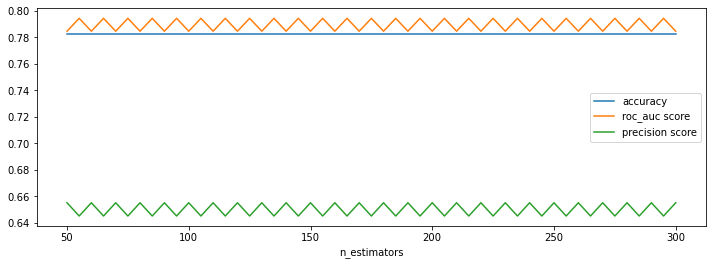

In [78]:
acc_score = []
roc_auc_sc = []
prec_score = []

for n in nest_vals:
    xgb_cl = xgb.XGBClassifier(n_estimators=int(n),
                               objective='binary:hinge',
                               eval_metric='rmse'
                              )
    xgb_cl.fit(Xs_train, ys_train)
    
    y_pred = xgb_cl.predict(Xs_test)
    acc = accuracy_score(ys_test, y_pred)
    prec = precision_score(ys_test, y_pred)
    acc_score.append(acc)
    prec_score.append(prec)
    probas = xgb_cl.predict_proba(Xs_test)
    positive_proba = probas[:, 1]
    roc_auc_sc.append(roc_auc_score(ys_test, positive_proba))

plt.figure(figsize=(12, 4))
plt.plot(nest_vals, acc_score, label='accuracy')
plt.plot(nest_vals, roc_auc_sc, label='roc_auc score')
plt.plot(nest_vals, prec_score, label='precision score')
plt.xlabel("n_estimators")
plt.legend()
pass

Wykres nie dodaje dużo wiedzy oprócz tego, że metryki można by uznać za niewrażliwe na n_estimators. Szczytom ROC_AUC odpowiadają dolinki Precission; jeśli w tym przypadku najważniejszą metryką jest Precission, to do ostatecznego modelu powinno się dobrać któreś parzyste n_estimators (wielokrotność 10ki).

#### 5.2 bias-variance tradeoff

Poszukam graficznego rozwiązania problemu overfittingu tego modelu. Teoria mówi, że wraz ze wzrostem złożoności modelu spada jego obciążenie i rośnie wariancja. Złożenie tych funkcji rozumiane ogólnie jako błąd modelu posiada swoje minimum, które jest optymalnym punktem pracy modelu. Przeuczenie zaczyna się 'na prawo' od tego punktu. 

**5.2.1 BVT - learning_rate**

In [79]:
lr_vals = np.linspace(0.01,
                      1,
                      num=51,
                      endpoint=True,
                      retstep=False,
                      dtype=None,
                      axis=0)
lr_vals

array([0.01  , 0.0298, 0.0496, 0.0694, 0.0892, 0.109 , 0.1288, 0.1486,
       0.1684, 0.1882, 0.208 , 0.2278, 0.2476, 0.2674, 0.2872, 0.307 ,
       0.3268, 0.3466, 0.3664, 0.3862, 0.406 , 0.4258, 0.4456, 0.4654,
       0.4852, 0.505 , 0.5248, 0.5446, 0.5644, 0.5842, 0.604 , 0.6238,
       0.6436, 0.6634, 0.6832, 0.703 , 0.7228, 0.7426, 0.7624, 0.7822,
       0.802 , 0.8218, 0.8416, 0.8614, 0.8812, 0.901 , 0.9208, 0.9406,
       0.9604, 0.9802, 1.    ])

In [80]:
Xs_trainN = np.array(Xs_train)
Xs_testN = np.array(Xs_test)
ys_trainN = np.array(ys_train)
ys_testN = np.array(ys_test)

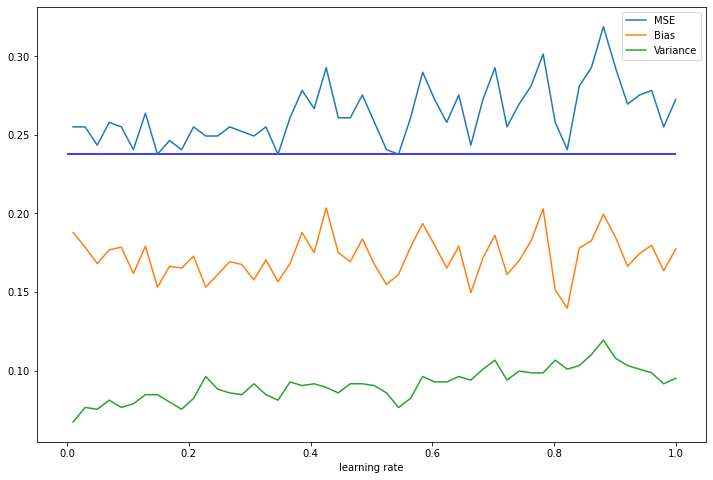

In [81]:
MSE_list = []
Bias_list = []
Variance_list = []
for l in lr_vals:
    xgb_cl = xgb.XGBClassifier(learning_rate=l,
                               objective='binary:hinge',
                               eval_metric='rmse')
    xgb_cl.fit(Xs_train, ys_train)
    mse, bias, var = bias_variance_decomp(xgb_cl,
                                          Xs_trainN,
                                          ys_trainN,
                                          Xs_testN,
                                          ys_testN,
                                          loss='mse',
                                          num_rounds=5,
                                          random_seed=997)
    MSE_list.append(mse)
    Bias_list.append(bias)
    Variance_list.append(var)
#     print('resulted error for learning rate: ', l)
#     print('MSE: %.3f' % mse)
#     print('Bias: %.3f' % bias)
#     print('Variance: %.3f' % var)
plt.figure(figsize=(12, 8))
plt.plot(lr_vals, MSE_list, label='MSE')
plt.plot(lr_vals, Bias_list, label='Bias')
plt.plot(lr_vals, Variance_list, label='Variance')
plt.hlines(min(MSE_list), xmin=0, xmax=1, color="b", linestyles='-')
plt.xlabel("learning rate")
plt.legend()
pass

Nie widzę jakiejś jasnej zależności błędu od learning_rate.<br>
Obciążenie zamiast maleć wydaje się jedynie bardziej rozstrzelone dla większych wartości l_r. <br>
Wariancja może ledwo rośnie, jednak nie widać minimum funkcji MSE. <br>
Na osi odciętych powien być ogólnie rozumiany stopień skomplikowania modelu; widać l_r może nie jest najlepszym parametrem do szukania punktu przeuczenia lub szukanie metodą graficzną się nie powiodło.

**5.2.2 BVT - n_estimators**

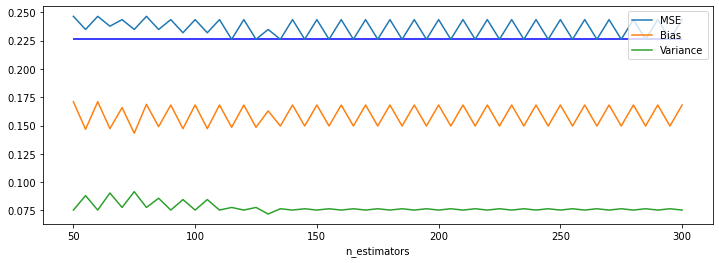

In [82]:
MSE_list = []
Bias_list = []
Variance_list = []
for n in nest_vals:
    xgb_cl = xgb.XGBClassifier(n_estimators=int(n),
                               objective='binary:hinge',
                               eval_metric='rmse',
                               )
    xgb_cl.fit(Xs_train, ys_train)
    mse, bias, var = bias_variance_decomp(xgb_cl,
                                          Xs_trainN,
                                          ys_trainN,
                                          Xs_testN,
                                          ys_testN,
                                          loss='mse',
                                          num_rounds=5,
                                          random_seed=997)
    MSE_list.append(mse)
    Bias_list.append(bias)
    Variance_list.append(var)

plt.figure(figsize=(12, 4))
plt.plot(nest_vals, MSE_list, label='MSE')
plt.plot(nest_vals, Bias_list, label='Bias')
plt.plot(nest_vals, Variance_list, label='Variance')
plt.hlines(min(MSE_list), xmin=50, xmax=300, color="b", linestyles='-')
plt.xlabel("n_estimators")
plt.legend()
pass

Cóż, to także nie potwierdziło zakładanej teorii i nie pozwala na wyznaczenie optymalnego bias-variance-tradeoff. Jedyne co tu widać to drobna stabilizacja wariancji przy ok 130 estymatorach.

#### 5.3 uczenie modelu metodą wbudowaną.

Skorzystam z metody xgb.cv do ustalenia przebiegu treningu. Na początek poszukam jeszcze optymalnego l_r wobec funkcji straty modelu.

learning rate: 0.01


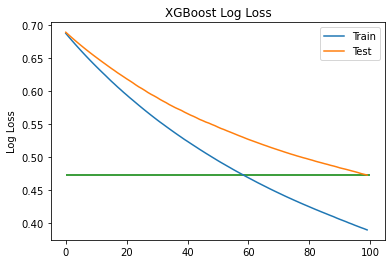

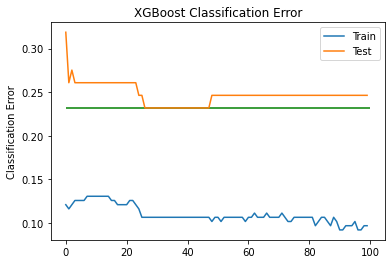

learning rate: 0.05


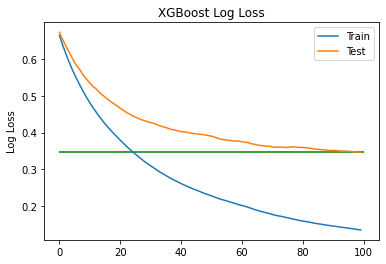

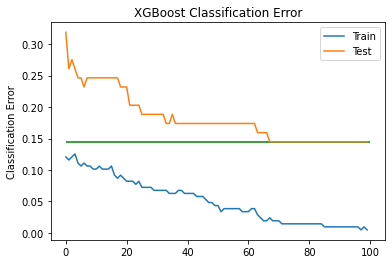

learning rate: 0.1


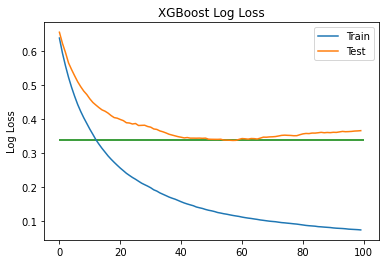

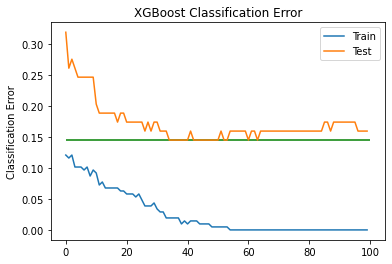

learning rate: 0.2


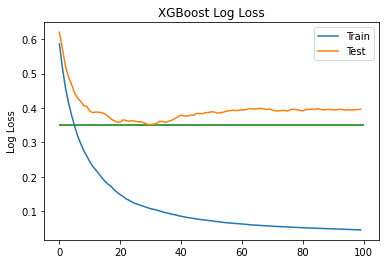

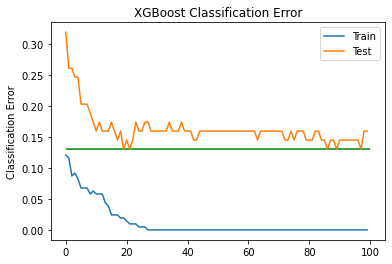

learning rate: 0.3


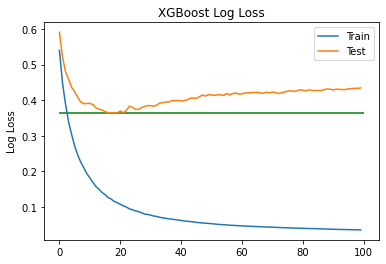

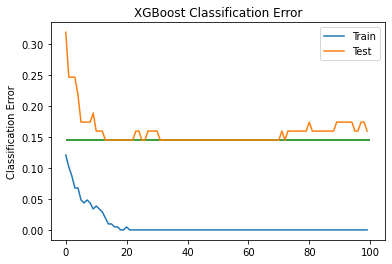

learning rate: 0.5


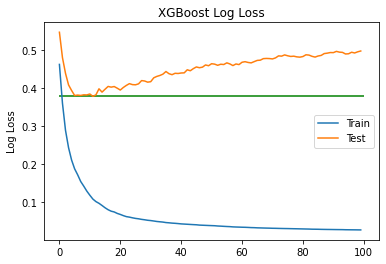

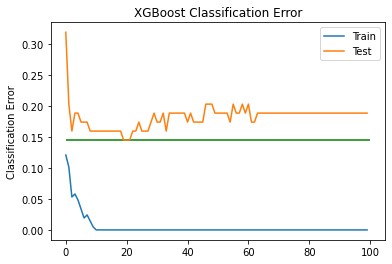

learning rate: 0.7


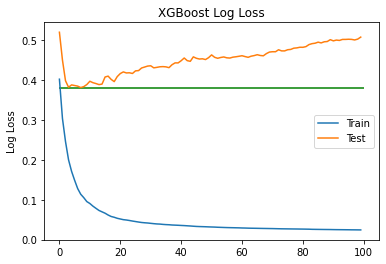

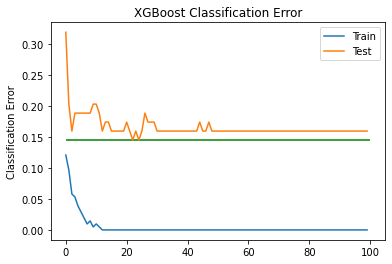

learning rate: 0.9


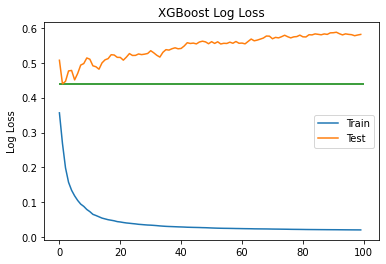

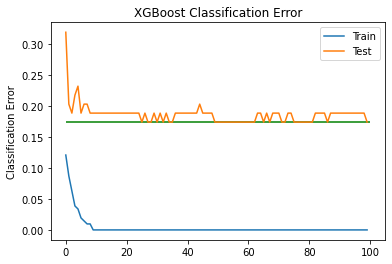

In [83]:
lr_vals = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]

for l in lr_vals:
    model = xgb.XGBClassifier(learning_rate = l)
    eval_set = [(Xs_train, ys_train), (Xs_test, ys_test)]
    model.fit(Xs_train,
              ys_train,
              eval_metric=["error", "logloss"],
              eval_set=eval_set,
              verbose=False)

    ys_pred = model.predict(Xs_test)
    predictions = [round(value) for value in ys_pred]

    accuracy = accuracy_score(ys_test, predictions)

    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)

    print ("learning rate:", l)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    plt.hlines(min(results['validation_1']['logloss']), xmin=0, xmax=100, color="g")
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    plt.hlines(min(results['validation_1']['error']), xmin=0, xmax=100, color="g")
    ax.legend()
    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error')
    plt.show()

Dla niskich wartości learing rate model charakteryzuje się wysokim błędem klasyfikacji. Z uwagi na małą ilosć obserwacji, nie sposób ocenić czy funkcja straty logarytmicznej jest możliwie najniższa. <br>
Dla wysokich wartości learning_rate zarówno logLoss jak i błąd estymacji (dla zboiru testowego) rosną. <br>
Najlepsze parametry model wykazuje dla learning rate = 0.2. Strata logarytmiczna stabilizuje się na poziomie ok. 0.4, w przeciwieństwie do analogicznych przebiegów dla wyższych l_r (gdzie ten wskaźnik wyraźnie rośnie) co oznacza przeuczenie tam właśnie.

In [84]:
dtrain = xgb.DMatrix(Xs_train, label=ys_train)
dtest = xgb.DMatrix(Xs_test, label=ys_test)
data_dm = xgb.DMatrix(data=Xs.values, label=ys.values)

In [85]:
params = {
    'objective': 'binary:hinge',
    'eval_metric': 'rmse',
    'learning_rate': 0.2
}
cv_results = xgb.cv(dtrain=data_dm,
                    params=params,
                    nfold=3,
                    num_boost_round=300,
                    metrics=["error", "auc"],
                    as_pandas=True)  #metrics="auc"

Text(0, 0.5, 'Wartość funkcji błędu')

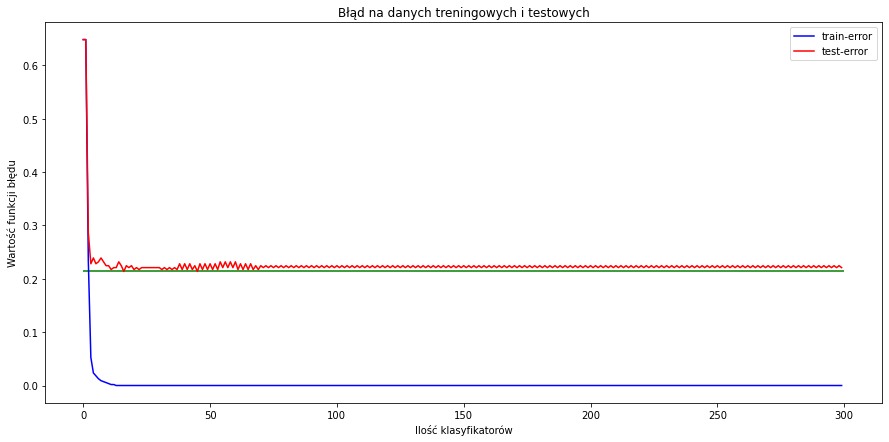

In [86]:
plt.figure(figsize=(15, 7))
plt.title("Błąd na danych treningowych i testowych")
plt.plot(cv_results["train-error-mean"], color="b")
plt.plot(cv_results["test-error-mean"], color="r")
# plt.ylim((0., 0.2))
plt.hlines([cv_results["test-error-mean"].min()], xmin=0, xmax=300, color="g")
plt.legend(["train-error", "test-error"])
plt.xlabel("Ilość klasyfikatorów")
plt.ylabel("Wartość funkcji błędu")

Text(0, 0.5, 'Wartość funkcji błędu')

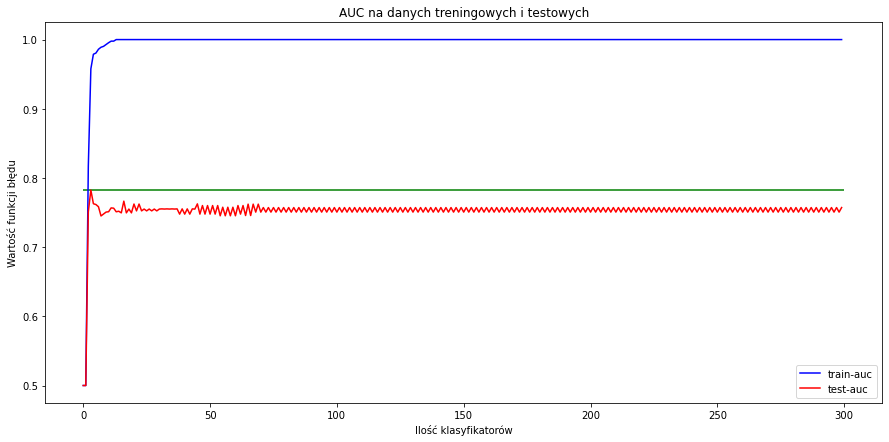

In [87]:
plt.figure(figsize=(15, 7))
plt.title("AUC na danych treningowych i testowych")
plt.plot(cv_results["train-auc-mean"], color="b")
plt.plot(cv_results["test-auc-mean"], color="r")
# plt.ylim((0., 0.2))
plt.hlines([cv_results["test-auc-mean"].max()], xmin=0, xmax=300, color="g")
plt.legend(["train-auc", "test-auc"])
plt.xlabel("Ilość klasyfikatorów")
plt.ylabel("Wartość funkcji błędu")

wartosć błędu estymacji stabilizuje się przy m/w 70 klasyfikatorach, jest więc to graniczny punkt n_estimators, powyżej którego rozpoznaje się przeuczenie.

Zobrazuję to wszystko na raz

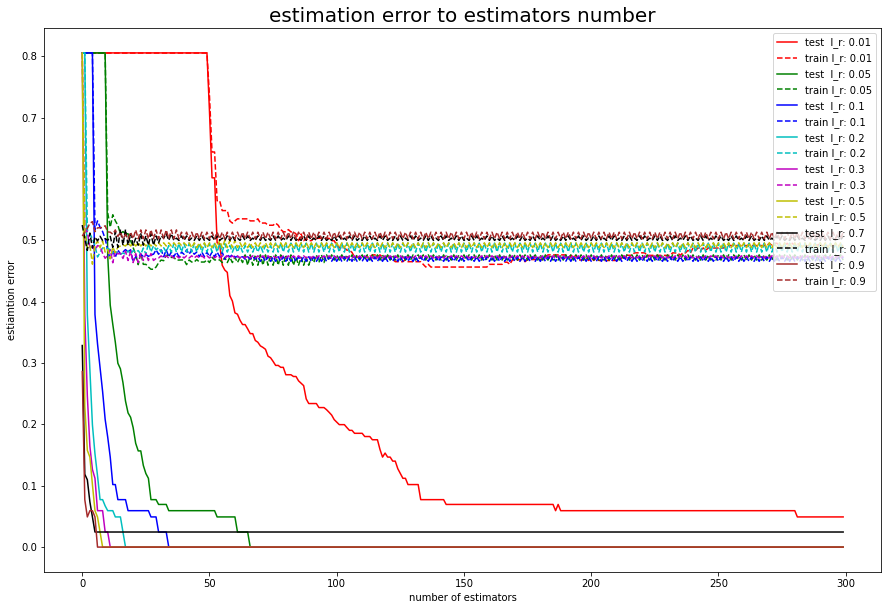

In [88]:
lr_vals = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]

params = {
    'objective': 'binary:hinge',
    'eval_metric': 'rmse',
    "learning_rate": 0.2
}

plt.figure(figsize=(15, 10))
legend = []
colors = ('r', 'g', 'b', 'c', 'm', 'y', 'black', 'brown')
for l in lr_vals:
    params['learning_rate'] = l
    cv_results = xgb.cv(dtrain=data_dm,
                        params=params,
                        nfold=3,
                        num_boost_round=300,
                        metrics='rmse',
                        as_pandas=True,
                        seed=997)
    plt.plot(cv_results['train-rmse-mean'], color=colors[lr_vals.index(l)])
    plt.plot(cv_results['test-rmse-mean'],
             ls='dashed',
             color=colors[lr_vals.index(l)])
    legend.append(f'test  l_r: {l}')
    legend.append(f'train l_r: {l}')
plt.legend(legend, loc='upper right')
plt.xlabel("number of estimators")
plt.ylabel("estiamtion error")
plt.title('estimation error to estimators number',
          fontsize=20)
plt.show()

postawię model i sprawdzę jego parametry 

In [89]:
model = xgb.XGBClassifier(learning_rate=0.2,
                          n_estimators=70,
                          objective='binary:hinge',
                          nfold=3,
                          num_boost_round=100,
                          as_pandas=True,
                          seed=997)

In [90]:
model.fit(Xs_train, ys_train)

[07:55:07] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(as_pandas=True, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=70, n_jobs=4, nfold=3, num_boost_round=100,
              num_parallel_tree=1, objective='binary:hinge', predictor='auto',
              random_state=997, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, seed=997, subsample=1, ...)

In [91]:
y_pred = model.predict(Xs_test)
acc = round(accuracy_score(ys_test, y_pred),3)
prec = round(precision_score(ys_test, y_pred),3)
probas = model.predict_proba(Xs_test)
positive_proba = probas[:, 1]
roc_auc = round(roc_auc_score(ys_test, positive_proba),3)

print(f"precission: {prec}")
print(f"accuracy  : {acc}")
print(f"ROC-AUC   : {roc_auc}")

precission: 0.645
accuracy  : 0.783
ROC-AUC   : 0.794


#### 5.4 trening modelu

learning_rate i n_estimators pozostawię tak jak dobrałem powyżej. Optymalizacja modelu będzie się opierać o niektóre, pozostałe hiperparametry.

In [92]:
def grid_combination(grid):
    total_params = 1 
    for par in grid:
        total_params  = total_params * len(grid[par])
    return total_params

In [93]:
param_grid_xgb_random = {
    'max_depth': [0, 3, 4, 5, 6, 8, 10, 12, 15],
    'lambda': [1, 2, 3, 4, 5, 10, 20, 25],
    'alpha': [0, 1, 2, 3, 4, 5, 6, 7],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': np.arange(0.1, 1.0, 0.2),
    'colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'colsample_bylevel': np.arange(0.1, 1.0, 0.1)
}
print(grid_combination(param_grid_xgb_random))

622080


In [94]:
start = time.time()
random_search_xgb = RandomizedSearchCV(model,
                                   param_distributions=param_grid_xgb_random,
                                   cv=5,
                                   n_iter=100, #!
                                   verbose=1, 
                                   scoring='precision',
                                   random_state=997)
random_search_xgb.fit(Xs, ys)
end = time.time()
print("time: ",end - start)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[07:55:55] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:55:55] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:55:55] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some 

[07:55:56] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:55:56] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:55:56] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:55:57] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:55:57] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:55:57] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:55:58] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:55:58] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:55:58] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:55:59] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:55:59] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:55:59] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:56:00] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:00] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:01] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:56:02] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:02] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:02] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:56:03] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:03] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:03] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:56:04] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:04] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:04] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:56:05] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:05] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:05] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:56:06] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:06] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:06] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:56:07] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:07] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:07] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:56:08] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:08] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:08] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:56:09] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:09] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:09] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:56:09] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:09] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:10] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:56:10] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:10] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:11] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:56:12] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:12] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:12] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:56:13] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:13] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:13] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:56:14] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:14] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:14] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:56:15] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:15] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:15] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

[07:56:16] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:16] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:56:16] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being m

In [95]:
ranks = random_search_xgb.cv_results_['rank_test_score']
score = random_search_xgb.cv_results_['mean_test_score']

n = 5

for i in range(n):
    idx = np.where(ranks == i + 1)[0][0]
    print(random_search_xgb.cv_results_['params'][idx])
    print(score[idx])

{'min_child_weight': 7, 'max_depth': 6, 'lambda': 20, 'gamma': 0.9000000000000001, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.2, 'alpha': 4}
0.7535631248546849
{'min_child_weight': 7, 'max_depth': 6, 'lambda': 5, 'gamma': 0.7000000000000001, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.30000000000000004, 'alpha': 7}
0.7138378862516793
{'min_child_weight': 7, 'max_depth': 4, 'lambda': 3, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.1, 'alpha': 0}
0.7115337995337996
{'min_child_weight': 3, 'max_depth': 12, 'lambda': 5, 'gamma': 0.1, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.1, 'alpha': 7}
0.7083636363636364
{'min_child_weight': 3, 'max_depth': 15, 'lambda': 20, 'gamma': 0.7000000000000001, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.9, 'alpha': 5}
0.7024886546625677


In [103]:
param_grid_xgb = {
    'learning_rate': [0.2],
    'n_estimators': [70],
    'max_depth': [4, 6, 12, 15],
    'lambda': [3, 5, 20],
    'alpha': [0, 4, 5, 7],
    'min_child_weight': [3, 7],
    'gamma': [0.1, 0.3, 0.7, 0.9],
    'colsample_bytree': [0.4, 0.6, 0.8],
    'colsample_bylevel': [0.1, 0.2, 0.3, 0.9]
}
print(grid_combination(param_grid_xgb))

4608


In [105]:
start = time.time()
grid_search_xgb = GridSearchCV(model,
                               param_grid=param_grid_xgb,
                               cv=4,
                               verbose=1,
                               n_jobs=-1,
                               scoring='precision')
grid_search_xgb.fit(Xs_train, ys_train)
end = time.time()
print("time: ", end - start)

Fitting 4 folds for each of 4608 candidates, totalling 18432 fits
[08:23:33] WARNING: ..\src\learner.cc:576: 
Parameters: { "as_pandas", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


time:  377.6523962020874


In [106]:
grid_search_xgb.best_params_

{'alpha': 0,
 'colsample_bylevel': 0.1,
 'colsample_bytree': 0.6,
 'gamma': 0.9,
 'lambda': 3,
 'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 70}

In [107]:
xgb_cl_opt = xgb.XGBClassifier(**grid_search_xgb.best_params_)
xgb_cl_opt.fit(Xs_train, ys_train)

[08:23:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=0.1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0.9, gpu_id=-1,
              importance_type=None, interaction_constraints='', lambda=3,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=70, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=3, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [113]:
y_pred_o = xgb_cl_opt.predict(Xs_test)
acc_o = round(accuracy_score(ys_test, y_pred_o),3)
prec_o = round(precision_score(ys_test, y_pred_o),3)
probas_o = xgb_cl_opt.predict_proba(Xs_test)
positive_proba_o = probas_o[:, 1]
roc_auc_o = round(roc_auc_score(ys_test, positive_proba_o),3)
print ("base model:")
print(f"precision : {prec}")
print(f"accuracy  : {acc}")
print(f"ROC-AUC   : {roc_auc}")
print()
print ("optimized model:")
print(f"precision : {prec_o}")
print(f"accuracy  : {acc_o}")
print(f"ROC-AUC   : {roc_auc_o}")

base model:
precision : 0.645
accuracy  : 0.783
ROC-AUC   : 0.794

optimized model:
precision : 0.704
accuracy  : 0.812
ROC-AUC   : 0.919


Udało się poprawić precyzję klasyfikatora; wracając do przebiegów z 5.1 można by wywnioskować, że więcej się nie wyciągnie z tego modelu. 
<br>Trening szłoby powtórzyć ustawiając inny parameter w scoringu i powalczyć np. także o pole pod krzywą ROC.

#### 5.5 model KNN

In [142]:
knn = KNeighborsClassifier()
knn.fit(Xs_train,ys_train)

KNeighborsClassifier()

In [144]:
y_pred_knn = knn.predict(Xs_test)
acc_knn = round(accuracy_score(ys_test, y_pred_knn),3)
prec_knn = round(precision_score(ys_test, y_pred_knn),3)
probas_knn = knn.predict_proba(Xs_test)
positive_proba_knn = probas_knn[:, 1]
roc_auc_knn = round(roc_auc_score(ys_test, positive_proba_knn),3)
print ("KNN base model:")
print(f"precision : {prec_knn}")
print(f"accuracy  : {acc_knn}")
print(f"ROC-AUC   : {roc_auc_knn}")

KNN base model:
precision : 0.826
accuracy  : 0.87
ROC-AUC   : 0.907


KNN na dzień dobry daje lepsze rezultaty od XGBoosta. Popracuję jeszcze nad nim.

In [145]:
roc_auc_train_error = []
roc_auc_test_error = []
acc_train_error = []
acc_test_error = []
prec_train_error = []
prec_test_error = []

for n in range(1, 16):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(Xs_train, ys_train)
    y_pred_knn = knn.predict(Xs_test)
    y_pred_knn_train = knn.predict(Xs_train)
    
    acc_knn_test = accuracy_score(ys_test, y_pred_knn)
    acc_knn_train = accuracy_score(ys_train, y_pred_knn_train)
    acc_train_error.append((accuracy_score(ys_train, y_pred_knn_train)))
    acc_test_error.append((accuracy_score(ys_test, y_pred_knn)))
    
    prec_knn_test = precision_score(ys_test, y_pred_knn)
    prec_knn_train = precision_score(ys_train, y_pred_knn_train)
    prec_train_error.append((precision_score(ys_train, y_pred_knn_train)))
    prec_test_error.append((precision_score(ys_test, y_pred_knn)))
    
    probas_knn_train = knn.predict_proba(Xs_train)[:, 1]
    probas_knn_test = knn.predict_proba(Xs_test)[:, 1]
    roc_auc_train_error.append((roc_auc_score(ys_train, probas_knn_train)))
    roc_auc_test_error.append((roc_auc_score(ys_test, probas_knn_test)))

<function matplotlib.pyplot.show(close=None, block=None)>

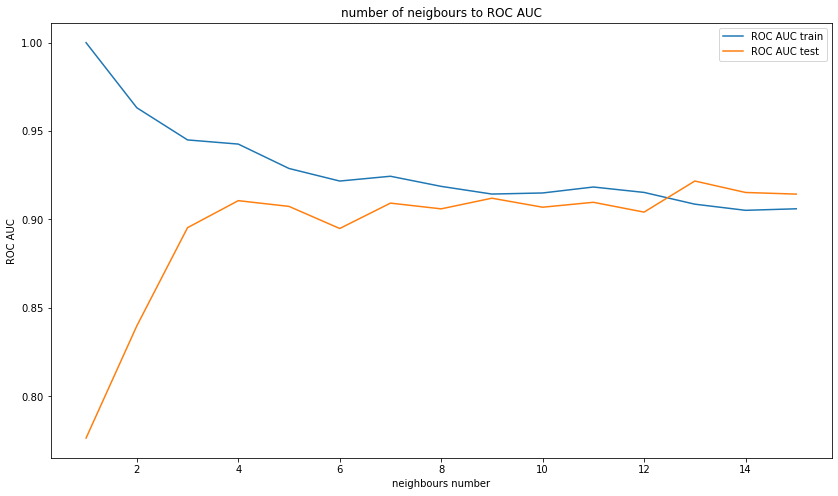

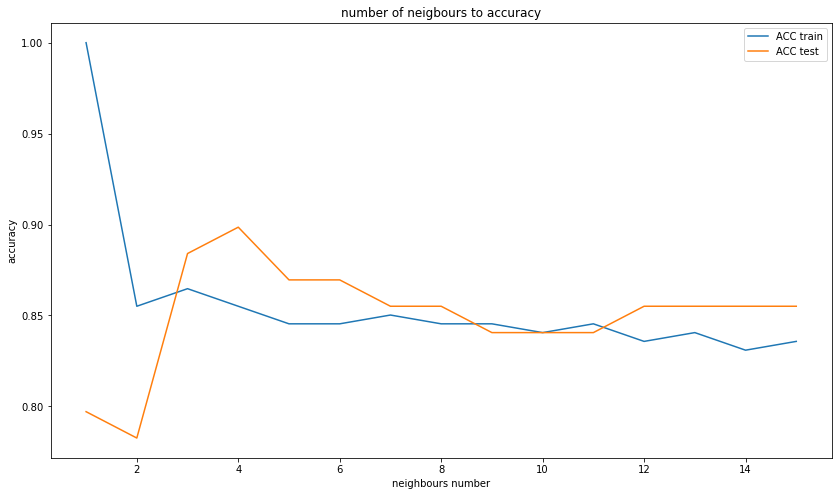

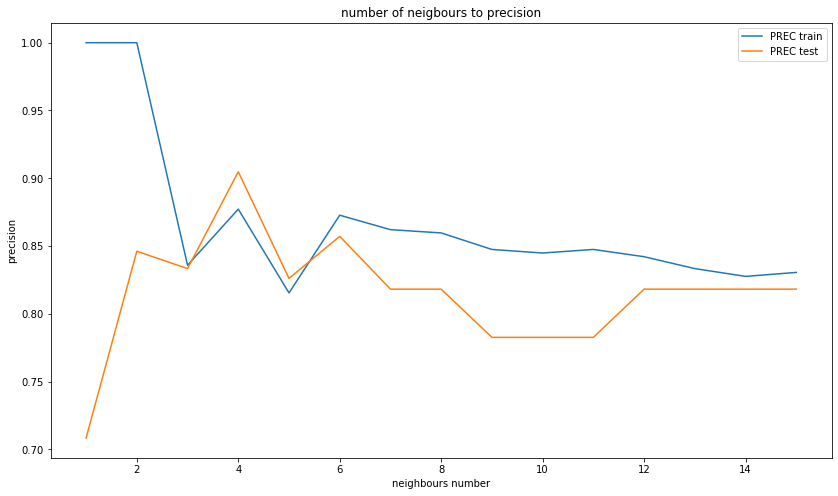

In [146]:
plt.figure(figsize=(14, 8))
plt.title('number of neigbours to ROC AUC')
plt.xlabel('neighbours number')
plt.ylabel('ROC AUC')
plt.plot(range(1,16), roc_auc_train_error, label='ROC AUC train')
plt.plot(range(1,16), roc_auc_test_error, label='ROC AUC test')
plt.legend()
plt.show
pass
plt.figure(figsize=(14, 8))
plt.title('number of neigbours to accuracy')
plt.xlabel('neighbours number')
plt.ylabel('accuracy')
plt.plot(range(1,16), acc_train_error, label='ACC train')
plt.plot(range(1,16), acc_test_error, label='ACC test')
plt.legend()
plt.show
pass
plt.figure(figsize=(14, 8))
plt.title('number of neigbours to precision')
plt.xlabel('neighbours number')
plt.ylabel('precision')
plt.plot(range(1,16), prec_train_error, label='PREC train')
plt.plot(range(1,16), prec_test_error, label='PREC test')
plt.legend()
plt.show

Z pierwszego wykresu można odczytać, że model jest dotrenowany dość wcześnie; już przy 4 sąsiadach pole pod ROC jest możliwie wysokie dla zbioru testowego, jednak model może być nieco niedouczony. Jednocześnie przy 6 obserwowalny jest lokalny spadek. obstawiałbym 7 sąsaidów. <br>
Z drugiego wykresu widać, że Accuracy także jest wysokie dla 4 sąsiadów natomiast przebieg dla zbioru treningowego wskazuje, że model jest dobrze dopasowany.<br>
Na trzecim wykresie znowu obserwowalny wzrost metryki przy N=4; stabilizacja treningu przy N=6, stabilizacja wyników zbioru testowego może przy N=7<br>
Ustawię N=4 i powiem, że to model zoptymalizowany.<br>
Warto zwrócić także uwagę na N=13, gdzie jest najwyższe AUC i stabilne charakterystyki treningowe.

In [148]:
knn_o = KNeighborsClassifier(n_neighbors=4)
knn_o.fit(Xs_train,ys_train)

KNeighborsClassifier(n_neighbors=4)

In [151]:
y_pred_knn_o = knn_o.predict(Xs_test)
acc_knn_o = round(accuracy_score(ys_test, y_pred_knn_o),3)
prec_knn_o = round(precision_score(ys_test, y_pred_knn_o),3)
probas_knn_o = knn_o.predict_proba(Xs_test)
positive_proba_knn_o = probas_knn_o[:, 1]
roc_auc_knn_o = round(roc_auc_score(ys_test, positive_proba_knn_o),3)

In [152]:
print ("XGB base model:")
print(f"precision : {prec}")
print(f"accuracy  : {acc}")
print(f"ROC-AUC   : {roc_auc}")
print()
print ("XGB optimized model:")
print(f"precision : {prec_o}")
print(f"accuracy  : {acc_o}")
print(f"ROC-AUC   : {roc_auc_o}")
print()
print ("KNN base model:")
print(f"precision : {prec_knn}")
print(f"accuracy  : {acc_knn}")
print(f"ROC-AUC   : {roc_auc_knn}")
print()
print ("KNN optimized model:")
print(f"precision : {prec_knn_o}")
print(f"accuracy  : {acc_knn_o}")
print(f"ROC-AUC   : {roc_auc_knn_o}")

XGB base model:
precision : 0.645
accuracy  : 0.783
ROC-AUC   : 0.794

XGB optimized model:
precision : 0.704
accuracy  : 0.812
ROC-AUC   : 0.919

KNN base model:
precision : 0.826
accuracy  : 0.87
ROC-AUC   : 0.907

KNN optimized model:
precision : 0.905
accuracy  : 0.899
ROC-AUC   : 0.911


### 6. Podsumowanie i wnioski

Dane zostały wyczyszczone i przygotowane do budowy modeli klasyfikacyjnych. Pominięto krok analizy danych pod kątem ich zrozumienia (jak kształtuje się relacja zmiennych do występowania chorób serca). 

Dobrano główną i pomocnicze metryki oceny modeli, ustanowiono modele a także okreslono ich granice przeuczenia. Modele dostały take dostrojone do zbioru danych z intencją polepszenia dominującej metryki.

Najlepszym predyktorem w tym przypadku okazał się KNN classifier z 4 centroidami.

### BRUDNOPIS

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel('Different Values of l')
plt.ylabel('Model score')
plt.plot(lr_vals, train_score, color = 'r', label = "training score")
plt.plot(lr_vals, test_score, color = 'b', label = 'test score')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.show()